In [1]:
! pip install transformers

In [1]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git
! git clone https://github.com/StepanTita/nano-BERT.git

Cloning into 'space-model'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 7), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (25/25), 2.10 MiB | 6.89 MiB/s, done.
Cloning into 'nano-BERT'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 56 (delta 25), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (56/56), 39.04 MiB | 9.88 MiB/s, done.


In [2]:
import sys

sys.path.append('space-model')

In [27]:
import math
import json
from collections import Counter
import random
import os

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

from space_model.model import SpaceModelForClassification, SpaceModel
from space_model.loss import *

In [4]:
SEED = 42

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=SEED)

In [6]:
def on_gpu(f):
    def wrapper():
        if torch.cuda.is_available():
            return f()
        else:
            print('cuda unavailable')
    return wrapper

In [7]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization():
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache():
    print("Initial GPU Usage")
    print_gpu_utilization()

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization()

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
data = None
with open('nano-BERT/data/imdb_train.json') as f:
    data = pd.DataFrame([json.loads(l) for l in f.readlines()])
data

,text,label
0,"["", Ko, to, tamo, peva, "", is, one, of, the, b...",pos
1,"[This, was, a, fine, example, of, how, an, int...",pos
2,"["", World, 's, Finest, "", is, an, unique, proj...",pos
3,"[The, second, alternate, Gundam, universe, tal...",pos
4,"[maybe, i, identify, with, this, film, cause, ...",pos
...,...,...
24995,"[Yeah, ,, that, about, sums, it, up, ., This, ...",neg
24996,"[It, was, everything, this, is, n't, :, it, ha...",neg
24997,"[This, show, comes, up, with, interesting, loc...",neg
24998,"[and, a, 30,000, $, budget, and, this, movie, ...",neg


In [10]:
test_data = None
with open('nano-BERT/data/imdb_test.json') as f:
   test_data = pd.DataFrame([json.loads(l) for l in f.readlines()])

In [11]:
def encode_label(label):
    if label == 'pos':
        return 1
    elif label == 'neg':
        return 0
    raise Exception(f'Unknown Label: {label}!')

class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, label_encoder, max_seq_len, inference=False):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.max_seq_len = max_seq_len
        self.inference = inference

    def __getitem__(self, index):
        sentence = ' '.join(self.data.text[index])

        if not self.inference:
            labels = self.label_encoder(self.data.label[index])

        inputs = tokenizer(sentence, max_length=self.max_seq_len, padding='max_length', truncation=True, return_tensors='pt')

        return {
            **{k: v.squeeze(0) for k, v in inputs.items()},
            'label_ids': torch.tensor(labels, dtype=torch.long) if not self.inference else []
        }

    def __len__(self):
        return self.len

In [41]:
MODEL_NAME = 'bert-base-uncased'

NUM_EPOCHS = 5
BATCH_SIZE = 256
MAX_SEQ_LEN = 256
LEARNING_RATE = 2e-4
MAX_GRAD_NORM = 1000

In [42]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [43]:
train_dataset = IMDBDataset(data, tokenizer, encode_label, MAX_SEQ_LEN)
test_dataset = IMDBDataset(test_data, tokenizer, encode_label, MAX_SEQ_LEN)

In [44]:
cls_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [45]:
for param in cls_bert.bert.parameters():
    param.requires_grad_(False)

In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [47]:
count_parameters(cls_bert)

1538

In [48]:
ids = train_dataset[0]['input_ids'].unsqueeze(0)
mask = train_dataset[0]['attention_mask'].unsqueeze(0)
targets = train_dataset[0]['label_ids'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

outputs = cls_bert(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(0.6425, device='cuda:0', grad_fn=<NllLossBackward0>)

In [49]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [50]:
@train
def train_epoch(model, train_dataloader, optimizer):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        targets = batch['label_ids'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets) # (B, Seq_Len, 2)

        loss, logits = outputs.loss, outputs.logits

        probs = F.softmax(logits, dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in targets.cpu()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss, train_preds, train_labels

@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label_ids'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            val_loss += loss.item()
    return val_loss, val_preds, val_labels

In [51]:
def training(model, train_data, val_data, config):
    model = model.to(device)

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])

    print(f'Train steps: {num_train_steps}')

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2 * config['batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
    }

    for epoch_num in range(config['epochs']):
        # train stage
        train_loss, train_preds, train_labels = train_epoch(model, train_dataloader, optimizer)

        # eval stage
        val_loss, val_preds, val_labels = eval_epoch(model, val_dataloader)
        
        # metrics
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds)
        val_precision = precision_score(val_labels, val_preds)
        train_recall = recall_score(train_labels, train_preds)
        val_recall = recall_score(val_labels, val_preds)

        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        print(f'Train recall: {train_recall} | Val recall: {val_recall}')
    return history

In [52]:
config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': 0,
    'fp16': False,
    'lr': LEARNING_RATE,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
}

In [53]:
history = training(cls_bert, train_dataset, test_dataset, config)

Train steps: 488


100%|██████████| 49/49 [06:32<00:00,  8.00s/it]



Train loss: 0.6799552160866407 | Val loss: 0.6545614344733102
Train acc: 0.56896 | Val acc: 0.64816
Train f1: 0.5689587834292703 | Val f1: 0.635741732798343
Train precision: 0.5687290703237123 | Val precision: 0.6082028511334424
Train recall: 0.57064 | Val recall: 0.8328


100%|██████████| 49/49 [05:47<00:00,  7.09s/it]



Train loss: 0.6458353844224191 | Val loss: 0.6252157420528178
Train acc: 0.65332 | Val acc: 0.7052
Train f1: 0.6533026213085167 | Val f1: 0.7038626912958614
Train precision: 0.6555221942708755 | Val precision: 0.6808885754583921
Train recall: 0.64624 | Val recall: 0.7724


100%|██████████| 49/49 [06:23<00:00,  7.83s/it]



Train loss: 0.6219088739278366 | Val loss: 0.6116622960080906
Train acc: 0.68364 | Val acc: 0.68608
Train f1: 0.6835641723560474 | Val f1: 0.6743846013351267
Train precision: 0.6895071410880872 | Val precision: 0.6349344471516417
Train recall: 0.66816 | Val recall: 0.8756


100%|██████████| 49/49 [05:54<00:00,  7.24s/it]



Train loss: 0.6082114358337558 | Val loss: 0.5945583521103373
Train acc: 0.696 | Val acc: 0.70224
Train f1: 0.6959676198218332 | Val f1: 0.6949140936777078
Train precision: 0.7001306975984316 | Val precision: 0.6543911078539147
Train recall: 0.68568 | Val recall: 0.8572


100%|██████████| 49/49 [06:23<00:00,  7.82s/it]


Train loss: 0.5945276131435316 | Val loss: 0.579324368919645
Train acc: 0.7054 | Val acc: 0.72472
Train f1: 0.7053264376919054 | Val f1: 0.7213334045475901
Train precision: 0.7121024370095002 | Val precision: 0.6841242789722076
Train recall: 0.6896 | Val recall: 0.83496


In [54]:
free_gpu_cache()

Initial GPU Usage
GPU memory occupied: 8630 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1856 MB.


In [55]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy
    
    if 'train_acc' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_acc'], label='train_acc')

        if do_val:
            ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score
    
    if 'train_f1' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_f1'], label='train_f1')

        if do_val:
            ax.plot(x, history['val_f1'], label='val_f1')

        plt.title('Train / Validation F1')
        plt.legend(loc='upper right')
    
    # precision
    
    if 'train_precision' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_precision'], label='train_precision')

        if do_val:
            ax.plot(x, history['val_precision'], label='val_precision')

        plt.title('Train / Validation Precision')
        plt.legend(loc='upper right')
    
    # recall
    
    if 'train_recall' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_recall'], label='train_recall')

        if do_val:
            ax.plot(x, history['val_recall'], label='val_recall')

        plt.title('Train / Validation Recall')
        plt.legend(loc='upper right')

    fig.show()

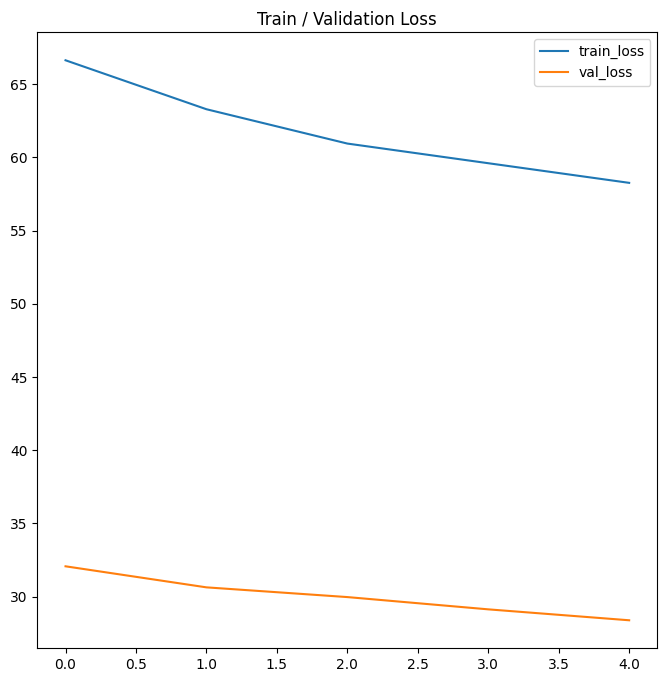

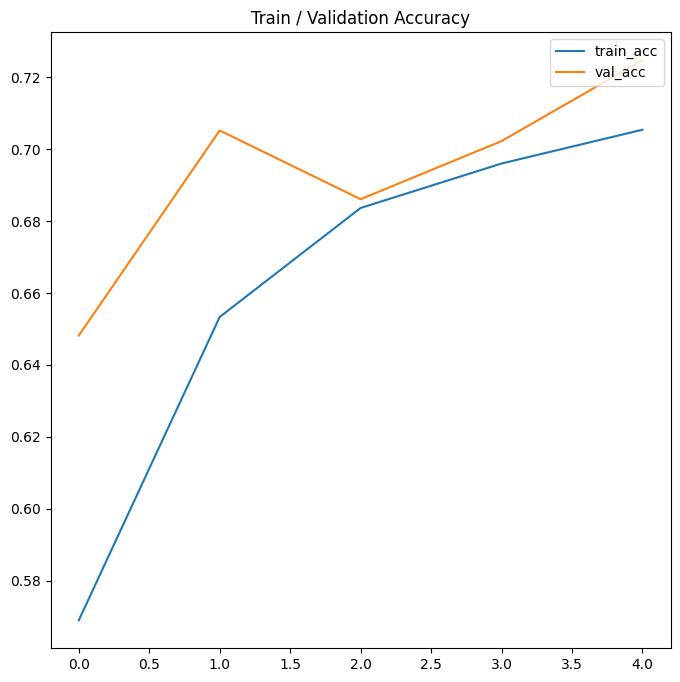

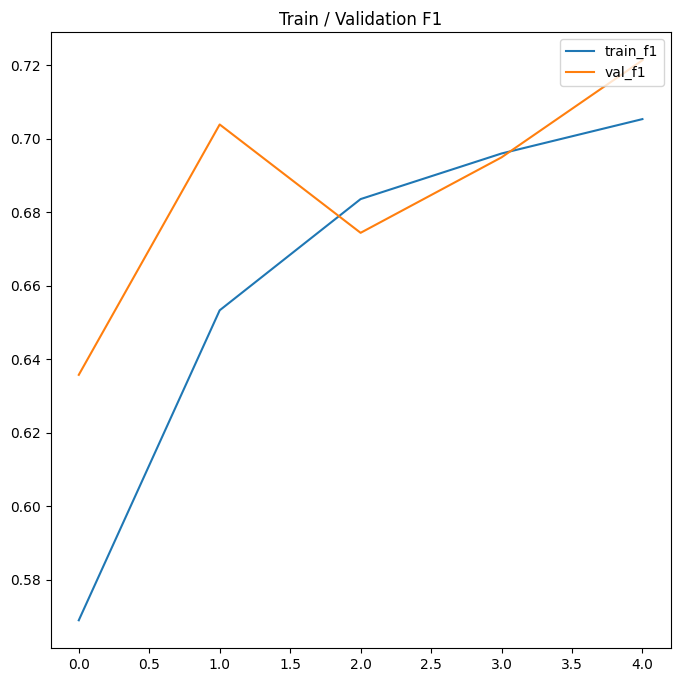

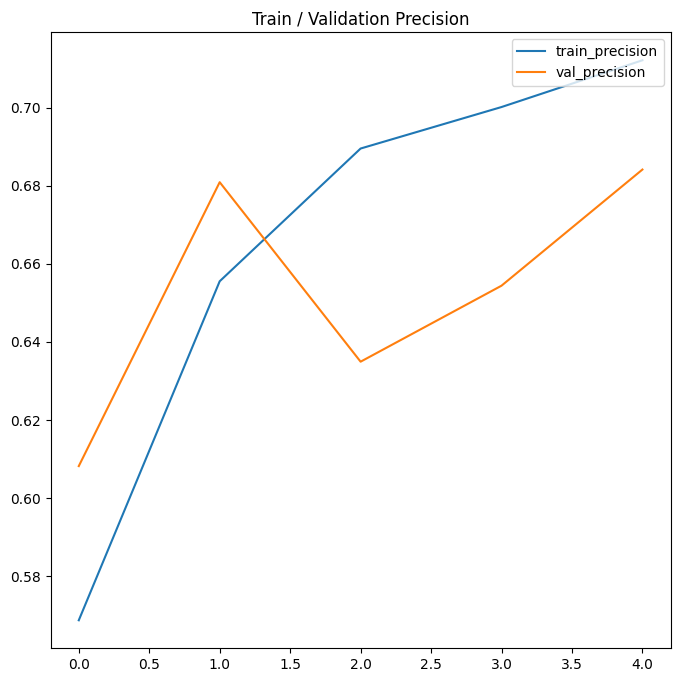

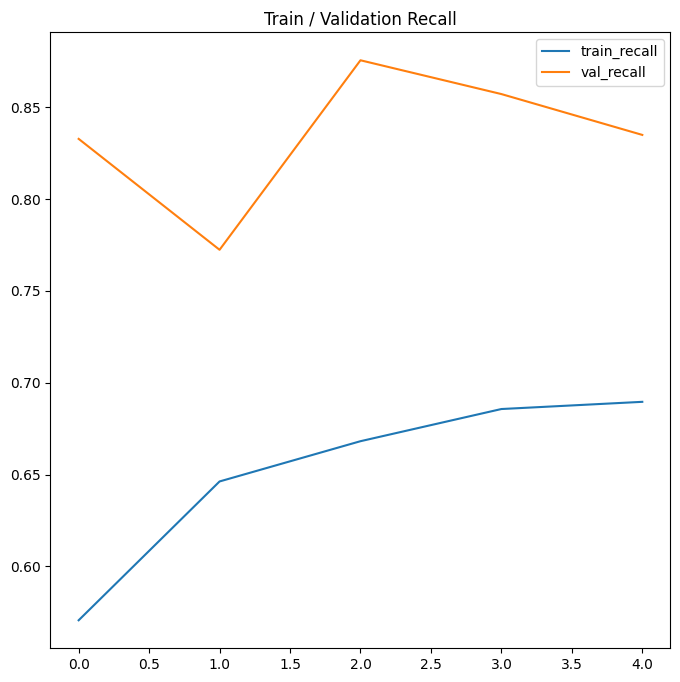

In [56]:
plot_results(history)

In [57]:
class SpaceModelForSequenceClassificationOutput:
    def __init__(self, loss=None, logits=None, concept_spaces=None):
        self.loss = loss
        self.logits = logits
        self.concept_spaces = concept_spaces

In [58]:
class SpaceBertForSequenceClassification(torch.nn.Module):
    def __init__(self, base_model, n_embed=3, n_latent=3, n_concept_spaces=2, dropout=0.1, l1=1e-3, l2=1e-4, fine_tune=True):
        super().__init__()

        if fine_tune:
            for p in base_model.parameters():
                p.requires_grad_(False)

        self.bert = base_model

        self.space_model = SpaceModel(n_embed, n_latent, n_concept_spaces, output_concept_spaces=True)

        # self.ffwd = torch.nn.Sequential(
        #     torch.nn.Linear(n_concept_spaces * n_latent, 2 * n_concept_spaces * n_latent),
        #     torch.nn.GELU(),
        #     torch.nn.Linear(2 * n_concept_spaces * n_latent, n_concept_spaces * n_latent),
        #     torch.nn.Dropout(dropout),
        # )

        self.classifier = torch.nn.Linear(n_concept_spaces * n_latent, n_concept_spaces)

        self.l1 = l1
        self.l2 = l2

    def forward(self, input_ids, attention_mask, labels=None):
        embed = self.bert(input_ids, attention_mask).last_hidden_state

        out = self.space_model(embed)

        concept_hidden = out.logits

        logits = self.classifier(concept_hidden)

        loss = 0.0
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
        loss += self.l1 * inter_space_loss(out.concept_spaces) + self.l2 * intra_space_loss(out.concept_spaces)

        return SpaceModelForSequenceClassificationOutput(loss, logits, out.concept_spaces)

In [59]:
bert = AutoModel.from_pretrained(MODEL_NAME)
bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [60]:
space_bert = SpaceBertForSequenceClassification(bert, n_embed=768, n_latent=3, n_concept_spaces=2)
space_bert

SpaceBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [61]:
count_parameters(space_bert)

4622

In [62]:
space_history = training(space_bert, train_dataset, test_dataset, config)

Train steps: 488


  0%|          | 0/98 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 49/49 [06:30<00:00,  7.97s/it]



Train loss: 0.8552391675053811 | Val loss: 0.9462040528959158
Train acc: 0.61264 | Val acc: 0.7432
Train f1: 0.6101449275362318 | Val f1: 0.7412177928855421
Train precision: 0.597103448275862 | Val precision: 0.7069716775599129
Train recall: 0.69264 | Val recall: 0.83072


  0%|          | 0/98 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 49/49 [06:30<00:00,  7.98s/it]



Train loss: 0.7854433734806217 | Val loss: 0.8997797005030573
Train acc: 0.77492 | Val acc: 0.77264
Train f1: 0.7740881785766215 | Val f1: 0.7692685580773513
Train precision: 0.7451665834344011 | Val precision: 0.7195593351372246
Train recall: 0.8356 | Val recall: 0.89352


  0%|          | 0/98 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 49/49 [06:25<00:00,  7.88s/it]



Train loss: 0.7438294127279398 | Val loss: 0.86251805753124
Train acc: 0.795 | Val acc: 0.79896
Train f1: 0.7947333829680429 | Val f1: 0.7983074571779845
Train precision: 0.7751660323856429 | Val precision: 0.768424077000431
Train recall: 0.83104 | Val recall: 0.85584


  0%|          | 0/98 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 49/49 [06:24<00:00,  7.85s/it]



Train loss: 0.7093264527466833 | Val loss: 0.8325603908422042
Train acc: 0.80268 | Val acc: 0.8128
Train f1: 0.8026659431847304 | Val f1: 0.8127950925356738
Train precision: 0.7976555739123594 | Val precision: 0.8160362107985775
Train recall: 0.81112 | Val recall: 0.80768


  0%|          | 0/98 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 49/49 [06:26<00:00,  7.88s/it]


Train loss: 0.6806782319837686 | Val loss: 0.8092017696828259
Train acc: 0.81288 | Val acc: 0.81752
Train f1: 0.8128721424264094 | Val f1: 0.8175192700770804
Train precision: 0.8169881666396499 | Val precision: 0.8162549800796812
Train recall: 0.8064 | Val recall: 0.81952


In [63]:
free_gpu_cache()

Initial GPU Usage
GPU memory occupied: 9034 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2116 MB.


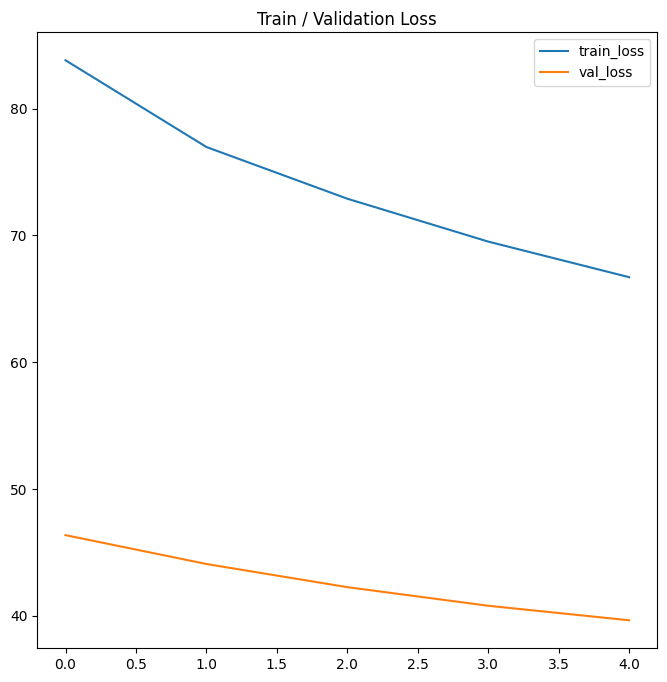

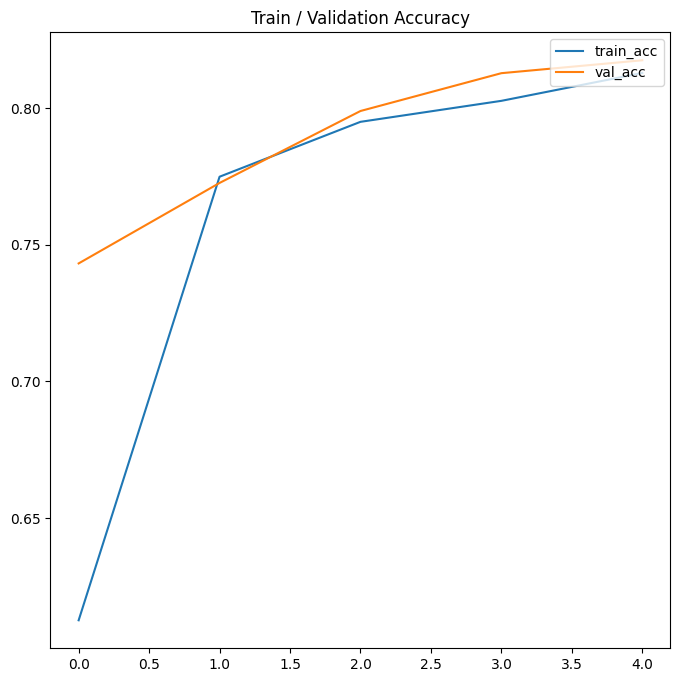

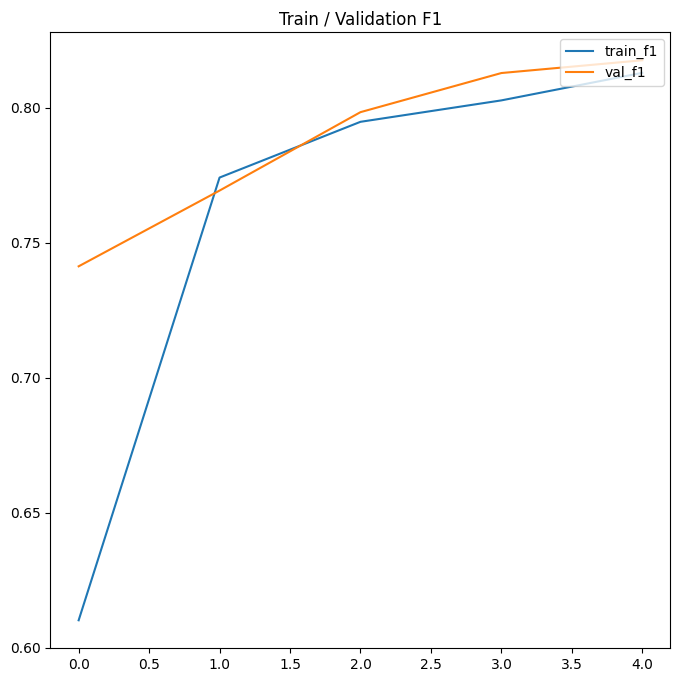

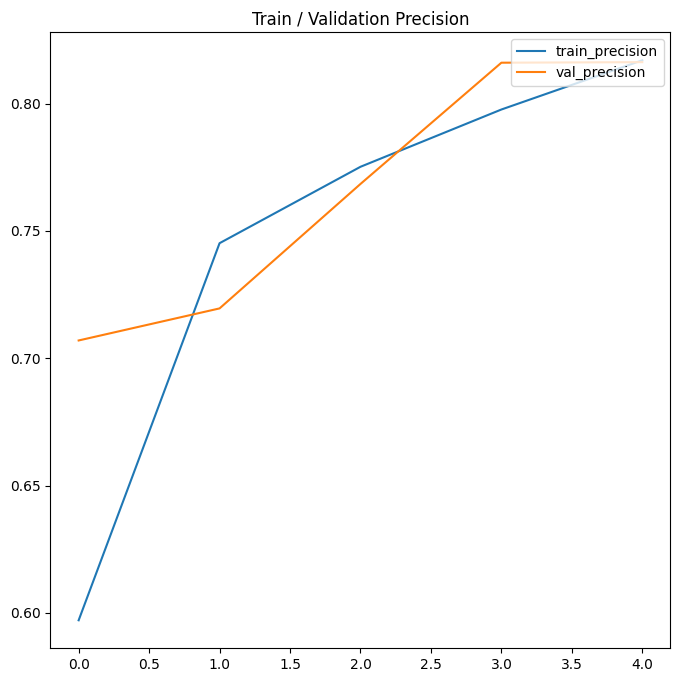

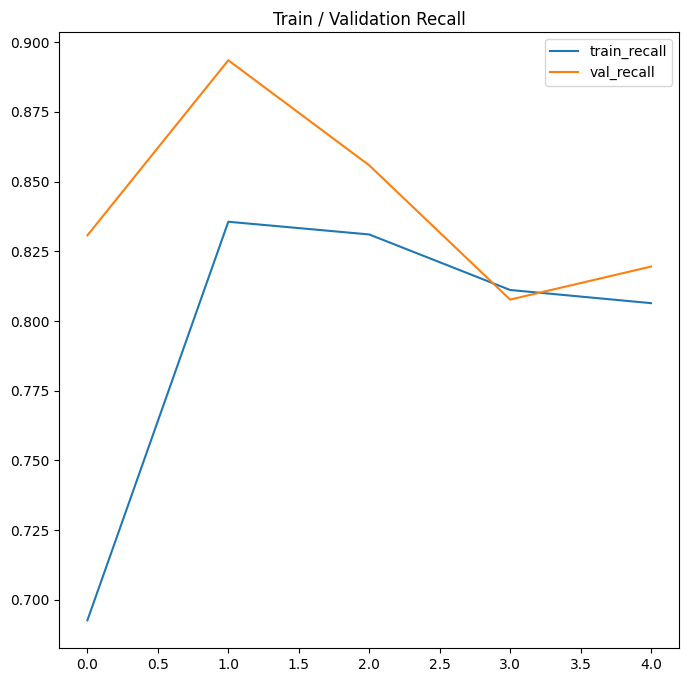

In [64]:
plot_results(space_history)

In [65]:
@train
def train_unsup_epoch(model, train_dataloader, optimizer):
    train_loss = 0.0

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask) # (B, Seq_Len, 2)

        loss, logits = outputs.loss, outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss

@eval
def eval_unsup_epoch(model, val_dataloader):
    val_loss = 0.0

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask)

            loss, logits = outputs.loss, outputs.logits

            val_loss += loss.item()
    return val_loss

In [66]:
def unsup_training(model, train_data, val_data, config):
    model = model.to(device)

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])

    print(f'Train steps: {num_train_steps}')

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2 * config['batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
    }

    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')
        # train stage
        train_loss = train_unsup_epoch(model, train_dataloader, optimizer)

        # eval stage
        val_loss = eval_unsup_epoch(model, val_dataloader)

        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
    return history

In [67]:
unsup_train, sup_train = train_test_split(data, random_state=SEED, test_size=0.2)

In [68]:
unsup_train_dataset = IMDBDataset(unsup_train.reset_index(drop=True), tokenizer, encode_label, MAX_SEQ_LEN)
sup_train_dataset = IMDBDataset(sup_train.reset_index(drop=True), tokenizer, encode_label, MAX_SEQ_LEN)

In [69]:
config['epochs'] = 2

In [70]:
unsup_history = unsup_training(space_bert, unsup_train_dataset, test_dataset, config)

Train steps: 156
Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 49/49 [06:22<00:00,  7.82s/it]



Train loss: 0.1434099290378486 | Val loss: 0.27312901737738626
Epoch: 2


100%|██████████| 49/49 [05:58<00:00,  7.31s/it]


Train loss: 0.1386157336255795 | Val loss: 0.2690245025620169


In [71]:
free_gpu_cache()

Initial GPU Usage
GPU memory occupied: 9034 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2116 MB.


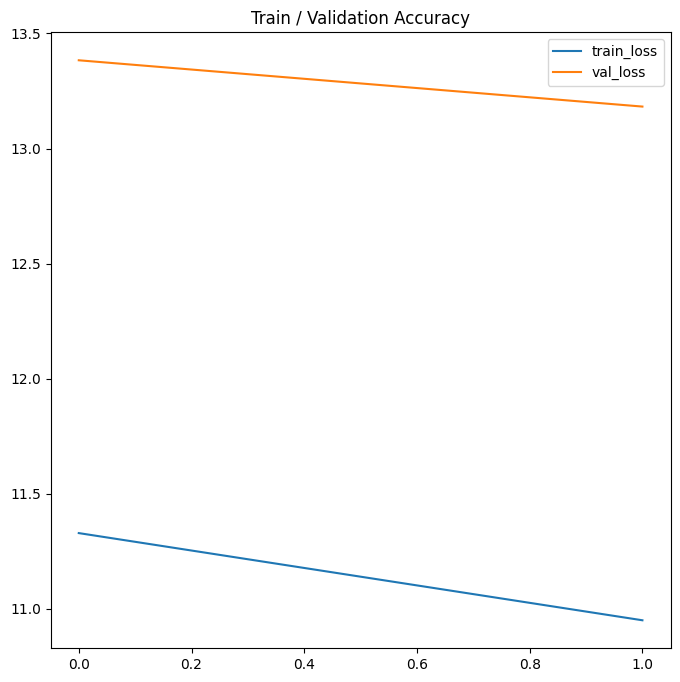

In [72]:
plot_results(unsup_history)

In [73]:
config['epochs'] = 1

In [74]:
sup_history = training(space_bert, sup_train_dataset, test_dataset, config)

Train steps: 19


100%|██████████| 49/49 [06:29<00:00,  7.94s/it]


Train loss: 0.8032501250505447 | Val loss: 0.895375699413066
Train acc: 0.5472 | Val acc: 0.63872
Train f1: 0.43526849989553473 | Val f1: 0.5885471797715361
Train precision: 0.9845559845559846 | Val precision: 0.959946949602122
Train recall: 0.10139165009940358 | Val recall: 0.28952


In [75]:
free_gpu_cache()

Initial GPU Usage
GPU memory occupied: 9034 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2116 MB.


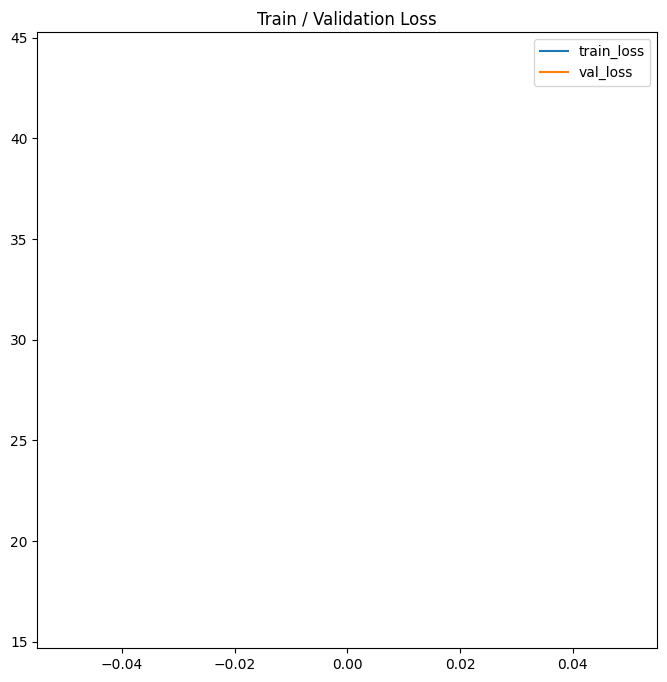

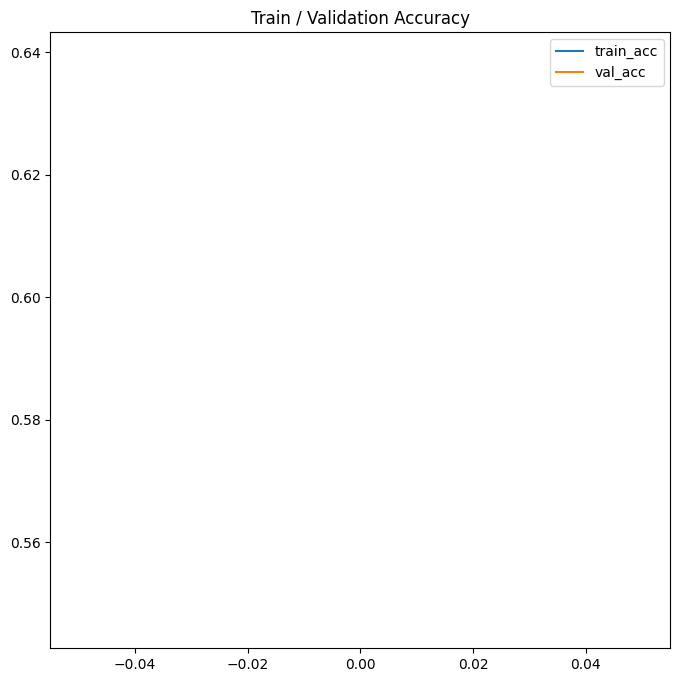

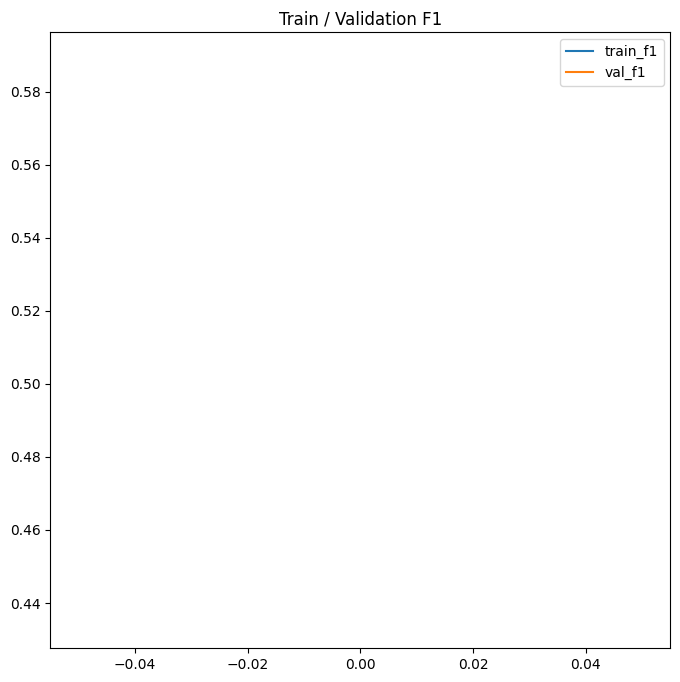

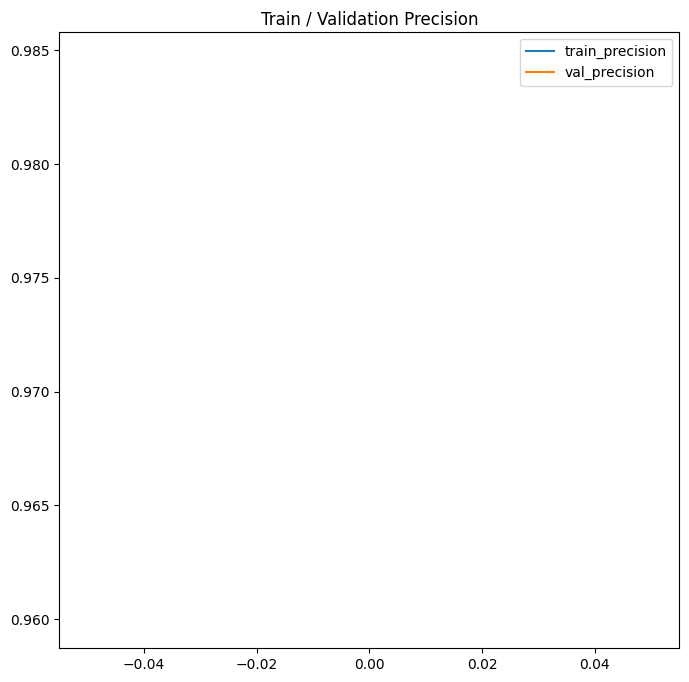

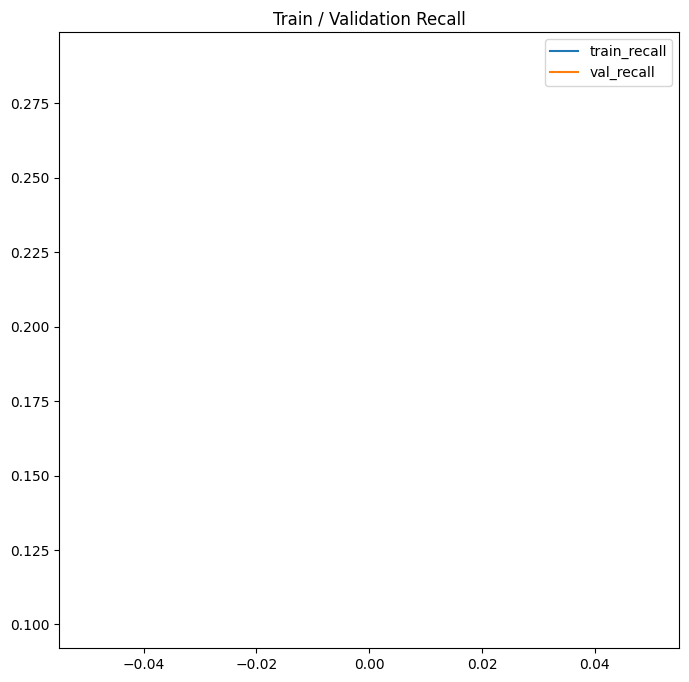

In [76]:
plot_results(sup_history)